In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [46]:
data = pd.read_csv('restaurant.csv')


# Data Cleansing


Index(['American', 'Australian', 'Austrian', 'Bangladeshi', 'Bar', 'Barbecue',
       'Brazilian', 'BrewPub', 'British', 'Cafe',
       ...
       'region_Steakhouse', 'region_Sushi', 'region_Swedish', 'region_Swiss',
       'region_Taiwanese', 'region_Thai', 'region_Turkish',
       'region_VeganOptions', 'region_Vietnamese', 'region_WineBar'],
      dtype='object', length=126)
Index(['Dinner', 'Lunch'], dtype='object')
(1230, 29)
Frequency Distributions:


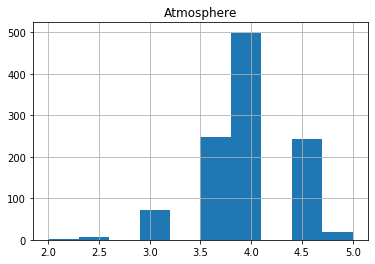

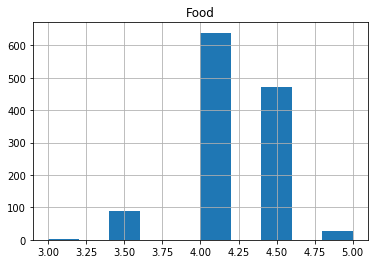

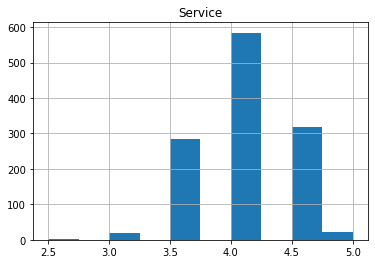

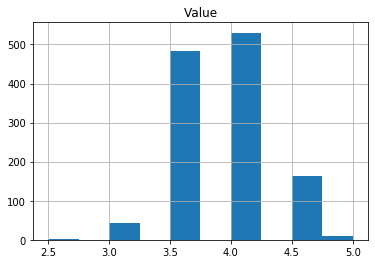

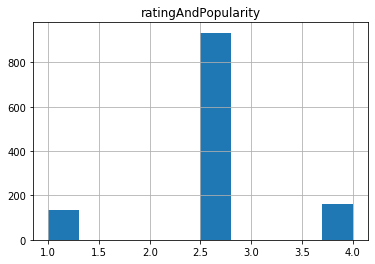

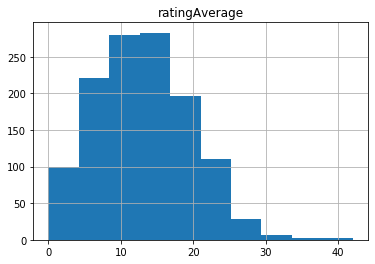

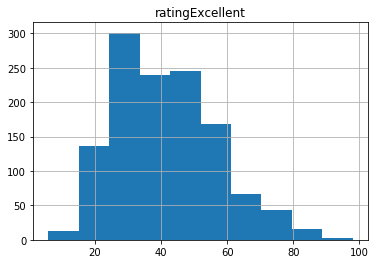

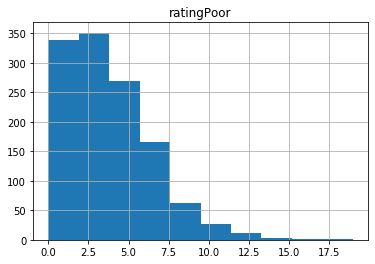

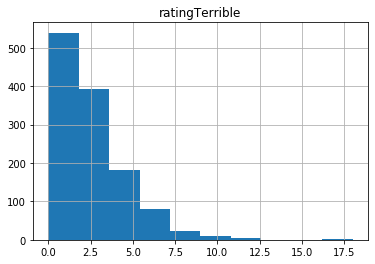

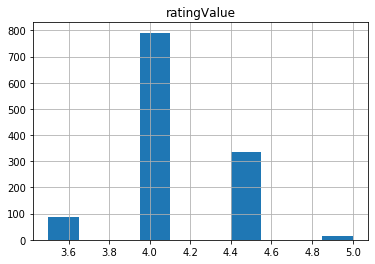

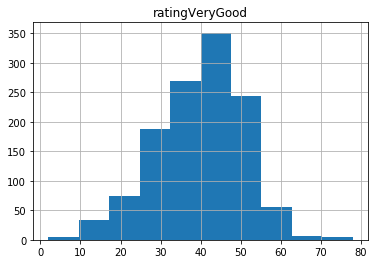

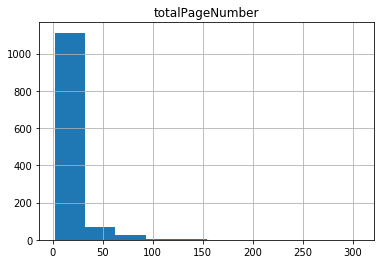

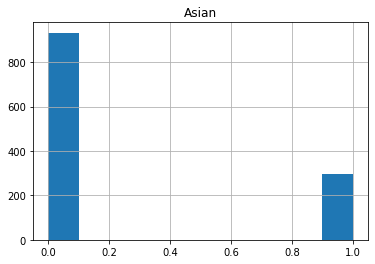

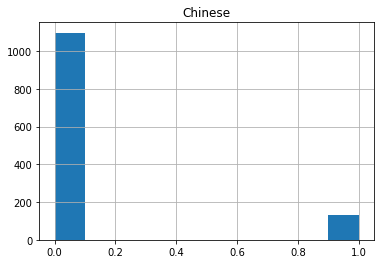

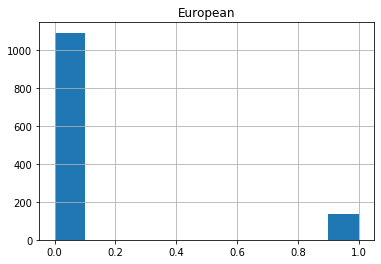

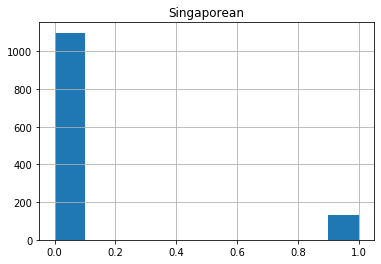

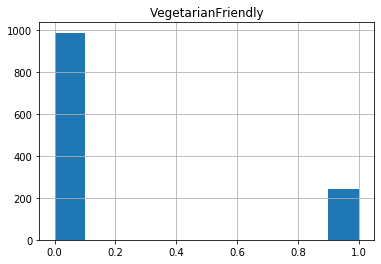

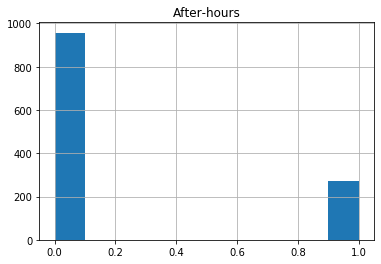

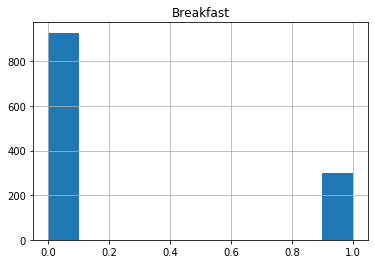

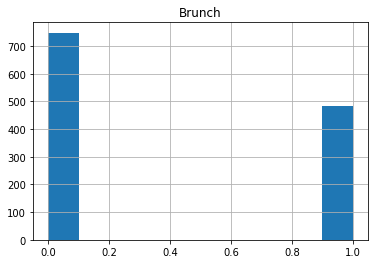

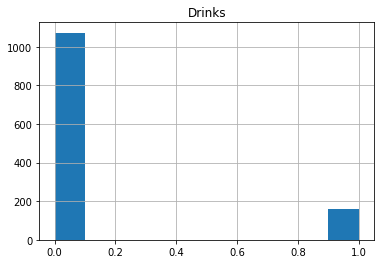

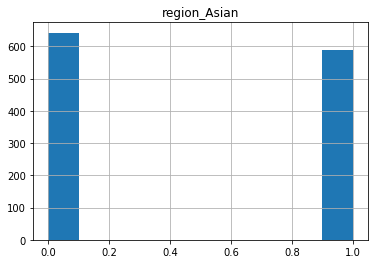

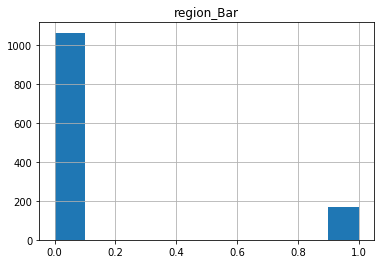

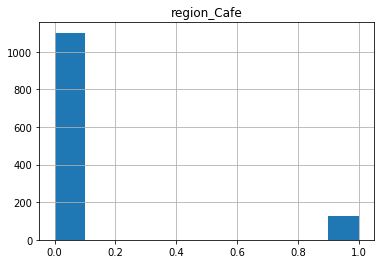

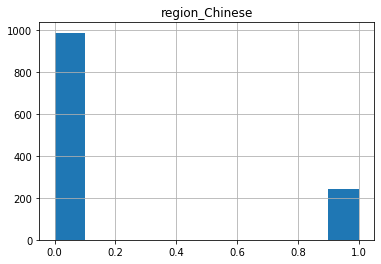

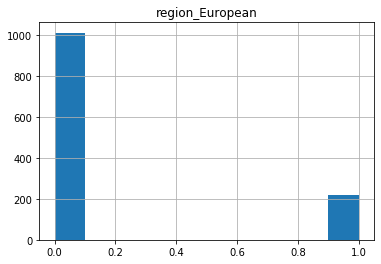

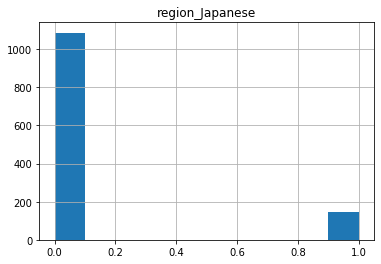

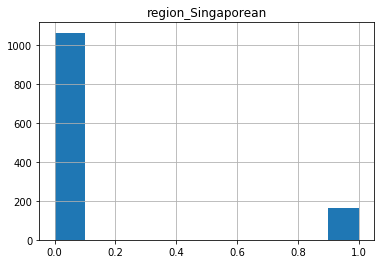

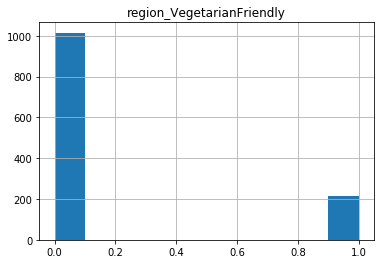

In [63]:
#drop below columns, as these info is free text type of data, which is unlikely to carry impactful info
new_data = data.drop(['_id', 'address', 'label', 'phone', 'restauranLink', 'restaurantName' ], axis = 1)

#convert ranking to numeric value for later PCA analysis
new_data['ranking'] = new_data['ranking'].str.split(' ', n=1, expand=True)[0].str.replace('#', '').str.replace(',' ,'')


#------------------------ Special Justification ---------------------------------------------------
#These 3 columns are a bit special, they are text based, but they seem contain categorical info. 
# I suspect that there could be cases that restaurants has more specific cuisine, e.g: American, or special service, 
# e.g: bar, could attract more good ratings, but specialized restaurant could be in dis-advantage as they have less
#services, due to this reason, I decided to convert the 3 columns into categorical columns, which will significantly 
#increase the total number of features.

new_data = new_data.join(new_data['cuisine'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['openMeal'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['region'].str.replace(' ', '').str.get_dummies(sep=',').add_prefix('region_'))

#drop text based data as it has been converted to numeric representation
new_data.drop(labels=['cuisine', 'openMeal', 'region'], axis=1,inplace = True)

#conver the $ to numeric value
def convert(col):
    col = str(col)
    if col == '$$$$':
        return  4
    elif col == '$$ - $$$':
        return 2.5
    elif col == '$$$':
        return 3
    elif col == '$$':
        return 2
    elif col == '$':
        return 1
    else:
        return 2.5

new_data['ratingAndPopularity'] = new_data['ratingAndPopularity'].apply(convert)

#------------------------ Special Justification ---------------------------------------------------
# Drop these columns: numbeOfReviews,numberAverage,numberExcellent,numberPoor,numberTerrible,numberVeryGood
# This is due to there are percentage based columns which deliver the same message:
# ratingAverage,ratingExcellent,ratingPoor,ratingTerrible,ratingVeryGood which is more meaningful than counts,
# As a new restaurant definitely has less number of counts than existing, but it could be a good restaurant

new_data.drop(labels=['numbeOfReviews', 'numberAverage', 'numberExcellent', 'numberPoor', 'numberTerrible', 'numberVeryGood'], axis=1,inplace = True)

#convert percentage string to float
new_data['ratingAverage'] = new_data['ratingAverage'].str.rstrip('%').astype('float') 
new_data['ratingExcellent'] = new_data['ratingExcellent'].str.rstrip('%').astype('float') 
new_data['ratingPoor'] = new_data['ratingPoor'].str.rstrip('%').astype('float') 
new_data['ratingTerrible'] = new_data['ratingTerrible'].str.rstrip('%').astype('float') 
new_data['ratingVeryGood'] = new_data['ratingVeryGood'].str.rstrip('%').astype('float') 

#Continue from previous assignment, 
# We used one-hot-encoding technique to transform those categorical type of data 
# columns into 1 or 0. But this will make number of columns into 158.

# But by looking into the data, there are many columns which had more than 90% of rows are either 1 or 0, which means 
#those columns' data do not have meaningful statistic feature, thus I decided to drop those columns 

drop_cols_0 = new_data.columns[(new_data == 0).sum() > 0.90*new_data.shape[0]]
print(drop_cols_0)
new_data.drop(drop_cols_0, axis = 1, inplace = True) 

drop_cols_1 = new_data.columns[(new_data == 1).sum() > 0.90*new_data.shape[0]]
print(drop_cols_1)
new_data.drop(drop_cols_1, axis = 1, inplace = True) 

#Drop Ranking columns as it is more like an sequence number instead of meaningful numeric data
new_data.drop(labels=['ranking'], axis = 1, inplace = True) 

#Drop pagenumber as I could not get the domain meaning of this column
# new_data.drop(labels=['totalPageNumber'], axis = 1, inplace = True) 

print(new_data.shape)

print("Frequency Distributions:")
for column in new_data:
    new_data[column].hist()
    plt.title(column)
    plt.show()

features = list(new_data)
colnames = np.transpose(features)


# Deal with missing Data and normalization

In [64]:
null_columns=new_data.columns[new_data.isnull().any()]
print(new_data[null_columns].isnull().sum())

from sklearn.preprocessing import Imputer
values = new_data.values

#------------------------ Justification --------------------------------------------
#Use median instead of mean, as mean may not represent most of the data and is greatly impacted by the outliners.

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
new_value = imputer.fit_transform(values)
new_data = pd.DataFrame(new_value)
sumry = new_data.describe().transpose()
print("Summary Statistics:\n",sumry,'\n')

data_std = StandardScaler().fit_transform(new_data)


Atmosphere         144
totalPageNumber     12
dtype: int64
Summary Statistics:
      count       mean        std  min   25%   50%   75%    max
0   1230.0   3.944715   0.429051  2.0   3.5   4.0   4.0    5.0
1   1230.0   4.174797   0.329483  3.0   4.0   4.0   4.5    5.0
2   1230.0   4.016667   0.397212  2.5   4.0   4.0   4.5    5.0
3   1230.0   3.843496   0.389679  2.5   3.5   4.0   4.0    5.0
4   1230.0   2.536585   0.735231  1.0   2.5   2.5   2.5    4.0
5   1230.0  13.021138   6.405059  0.0   8.0  13.0  17.0   42.0
6   1230.0  41.327642  15.338782  6.0  29.0  39.0  51.0   98.0
7   1230.0   3.473984   2.842298  0.0   1.0   3.0   5.0   19.0
8   1230.0   2.306504   2.233965  0.0   0.0   2.0   3.0   18.0
9   1230.0   4.114228   0.293267  3.5   4.0   4.0   4.5    5.0
10  1230.0  39.870732  10.959740  2.0  33.0  41.0  48.0   78.0
11  1230.0  14.678049  19.244656  2.0   5.0   9.0  18.0  306.0
12  1230.0   0.241463   0.428145  0.0   0.0   0.0   0.0    1.0
13  1230.0   0.107317   0.309642  0.0 

c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


# Run KMeans


In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for n_clusters in range(5, 100):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(data_std)

    # plt.scatter(data_std[:, 2], data_std[:, 3], c=preds, s=50, cmap='viridis')
    # plt.title(n_clusters)
    # plt.show()

    centers = clusterer.cluster_centers_

    score = silhouette_score (data_std, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))


For n_clusters = 5, silhouette score is 0.1098228427689682)
For n_clusters = 6, silhouette score is 0.13289166624398138)
For n_clusters = 7, silhouette score is 0.12965680787362277)
For n_clusters = 8, silhouette score is 0.13147221192723169)
For n_clusters = 9, silhouette score is 0.13382670643271016)
For n_clusters = 10, silhouette score is 0.13407679435096906)
For n_clusters = 11, silhouette score is 0.13865588242526342)
For n_clusters = 12, silhouette score is 0.1328520291082147)
For n_clusters = 13, silhouette score is 0.13643021608796352)
For n_clusters = 14, silhouette score is 0.12462918210431953)
For n_clusters = 15, silhouette score is 0.12638120878163603)
For n_clusters = 16, silhouette score is 0.12013867702897023)
For n_clusters = 17, silhouette score is 0.12086699943780715)
For n_clusters = 18, silhouette score is 0.118512103812333)
For n_clusters = 19, silhouette score is 0.11996897279412726)
For n_clusters = 20, silhouette score is 0.12243907818099248)
For n_clusters = 

# Analysis
This has shown that the performance is really bad, highest silhouette score is only 0.11


# Run PCA


In [66]:
n_components = len(features)
pca = PCA(n_components).fit(data_std)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_

# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
# print('Loading Matrix:')
loadings= np.sqrt(eigval)*eigvec
# print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 60 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')



Eigenvectors (Linear Coefficients):
                                PC1       PC2       PC3       PC4       PC5  \
Atmosphere                 0.229793 -0.126938  0.069352  0.006888  0.124905   
Food                       0.310082  0.178984 -0.050994 -0.006915 -0.099344   
Service                    0.341691 -0.012520 -0.018005  0.006707  0.020876   
Value                      0.242754  0.217820 -0.081643  0.175192  0.033674   
ratingAndPopularity        0.140564 -0.154432  0.078039 -0.326202 -0.110712   
ratingAverage             -0.322121 -0.094954 -0.033404  0.010710 -0.025717   
ratingExcellent            0.394799  0.045604  0.060427 -0.014511  0.060043   
ratingPoor                -0.201434 -0.204253  0.106713 -0.175244 -0.028632   
ratingTerrible            -0.182578 -0.181550  0.149866 -0.180363 -0.025836   
ratingValue                0.365049  0.111191 -0.052805  0.085939  0.071956   
ratingVeryGood            -0.274836  0.081645 -0.123271  0.096263 -0.056312   
totalPageNumber

# Loading Plot


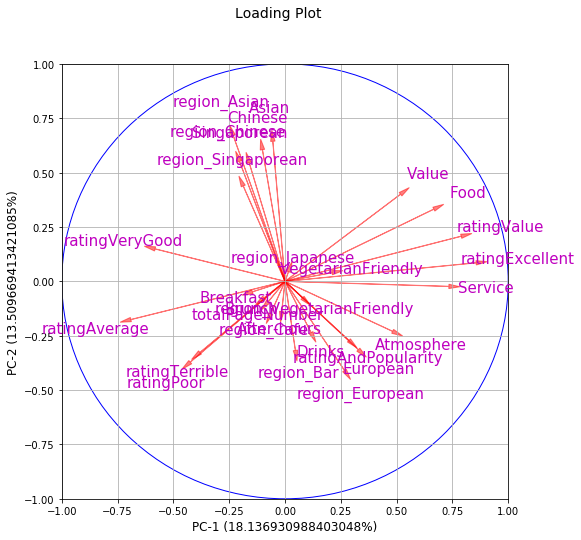

In [67]:
# (8) Loadings Plot
coeff = loadings[:,0:2]
fig = plt.figure(figsize=(8,8))
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.suptitle('Loading Plot',fontsize=14)
plt.xlabel('PC-1 ('+str(var_expln[0])+'%)',fontsize=12)
plt.ylabel('PC-2 ('+str(var_expln[1])+'%)',fontsize=12)

for i in range(len(coeff[:,0])):
    plt.arrow(0,0,coeff[i,0],coeff[i,1],color='r',
              alpha=0.5,head_width=0.02, head_length=0.05,length_includes_head=True)
    plt.text(coeff[i,0]*1.15,coeff[i,1]*1.15,features[i],fontsize=15,
             color='m',ha='center',va='center')

circle = plt.Circle((0, 0), 0.9999999,  color='b', fill=False)
ax = fig.gca() 
ax.add_artist(circle)
plt.grid()
plt.show()


# Scree plot


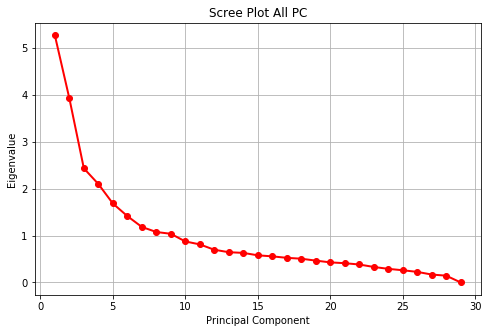

In [68]:
num_vars= len(features)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=2)
plt.title('Scree Plot All PC')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()



# Analysis
Compare with previous approach (without removing irrelevant/data insignificant columns

I noticed the Eigenvalues dropped to below 1 at 10th PC, at 12 th PC, its cumulative value is 77%.

I choose the first 12 components in future analysis.



# Run k-means with Principle components


For n_clusters = 5, silhouette score is 0.14951525443779687)
For n_clusters = 6, silhouette score is 0.16534541348927959)
For n_clusters = 7, silhouette score is 0.16359689111603637)
For n_clusters = 8, silhouette score is 0.17047053083461677)
For n_clusters = 9, silhouette score is 0.17566350429750102)
For n_clusters = 10, silhouette score is 0.17961872869215892)
For n_clusters = 11, silhouette score is 0.18354240745858771)
For n_clusters = 12, silhouette score is 0.18248771432345892)
For n_clusters = 13, silhouette score is 0.17297050209348896)
For n_clusters = 14, silhouette score is 0.17382586373263467)
For n_clusters = 15, silhouette score is 0.17335529689209672)
For n_clusters = 16, silhouette score is 0.17238828046388183)
For n_clusters = 17, silhouette score is 0.1620045819957363)
For n_clusters = 18, silhouette score is 0.16572519852707343)
For n_clusters = 19, silhouette score is 0.15882286096345993)
For n_clusters = 20, silhouette score is 0.16638574768230677)
For n_clusters

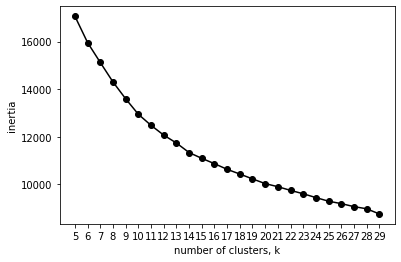

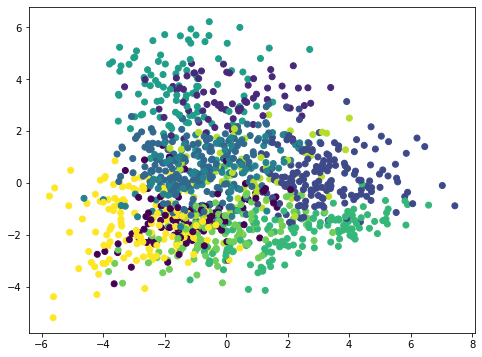

In [85]:
pca = PCA(n_components=12)
principalComponents = pca.fit_transform(data_std)
PCA_components = pd.DataFrame(principalComponents)

inertias = []

iterations = range(5, 30)
for n_clusters in iterations:
    model = KMeans (n_clusters=n_clusters)
    preds = model.fit_predict(PCA_components)

    centers = model.cluster_centers_
    inertias.append(model.inertia_)

    score = silhouette_score (PCA_components, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(iterations, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(iterations)
plt.show()

#Here we will choose number of cluster as 10
model = KMeans(n_clusters=10)
preds = model.fit_predict(PCA_components)


plt.figure(figsize=(8, 6))
plt.scatter(principalComponents[:,0], principalComponents[:,1], c=model.labels_)
plt.show()
